# Recurrent Neural Networks

RNNs are a family of neural networks for processing sequential data. 

We have seen how convolutional neural networks are specialized in processing a grid of values $X$. In the same way, RNNs are specialized in processing a sequence of values $x^{(1)}, x^{(2)}, \dots, x^{(\tau)}$. 

To go from MLP to RNN, we again need to take advantage of parameter sharing so that we can process sequences of arbitrary length (just like we did with CNNs for images of arbitrary size). In other words, if we used an MLP, the input layer has a fixed dimensionality, which we do not want. Some sequences may be shorter or longer than other sequences. 

Of course, we could use a 1-D convolution operation on a sequence of data, for which parameter sharing is still applied and this approach is scalable to arbitrary sequence lengths. This is actually the basis for [time-delay networks](https://en.wikipedia.org/wiki/Time_delay_neural_network). However, this type of parameter sharing is not the same as that of RNNs. Using a 1-D convolution means that the output is a product of the input and a small neighbourhood around the input at each time point of the sequence. RNNs instead compute the output based on every single input that came before a specific time step. 

In [130]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

## Sequential models

Before delving into RNNs, let's specify what we mean by sequence modeling. A very naive approach is to look at the last $\tau$ instances to predict the next instance in the sequence. 

This type of sequence model is called a **Markov chain model**, and mathematically, it is defined as:

$P(y^{(t+1)} \;|\; y^{(t)}, y^{(t-1)}, \dots, y^{(t-\tau-1)}, y^{(t-\tau)})$

In other words, it models the probability of an output $y$ at time step $t+1$ based on all previous $y$ outputs from time step $t$ to $t-\tau$.

For example, if $\tau = 3$, we get

$P(y^{(t+1)} \;|\; y^{(t)}, y^{(t-1)}, y^{(t-2)}, y^{(t-3)})$

- The conditioning set $\{y^{(t)}, y^{(t-1)}, y^{(t-2)}, y^{(t-3)}\}$ of this probability can be seen as the **input** to our model. 
- The value we are calculating the probability over, i.e., $y^{(t+1)}$ can be seen as the **output** of our model.
- The probability function itself can be seen as the **model** we are attempting to approximate. 

Since our inputs and output always have a fixed length, we can use a linear regression model to predict the relationship between inputs and output.  

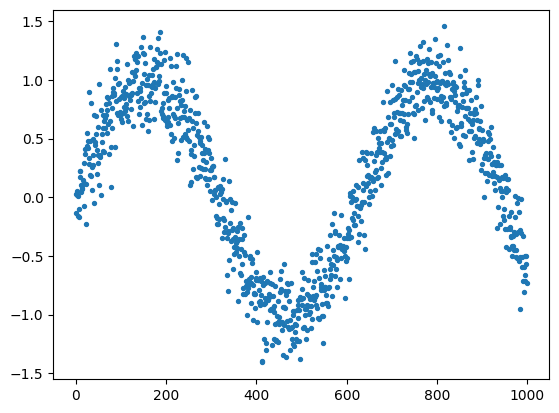

In [131]:
# let's generate a sine wave sequence with a bit of noise
N = 1000
x = torch.arange(0, N, 1)
y = torch.sin(0.01 * x) + torch.normal(0, 1, size=(N,)) * 0.2

plt.scatter(x, y, s=8)

Here, we implement our own linear regression model using PyTorch

In [132]:
from torch.utils.data import DataLoader
from torch.optim import SGD

class LinearRegression(nn.Module):
    def __init__(self, alpha=0.1, batch_size=32, epochs=10, learning_rate=0.01) -> None:
        super().__init__()
        self.alpha = alpha                      # regularization parameter
        self.batch_size = batch_size            # number of batches to process at one time
        self.epochs = epochs                    # number of epochs to train the model
        self.learning_rate = learning_rate      # optimization step size
        self.net = nn.LazyLinear(1)             # simple linear layer
        self.net.weight.data.normal_(0, 0.01)   # initialize weights to be gaussian N(0, 0.01)
        self.net.bias.data.fill_(0)             # initialize bias to be zero
        self.criterion = nn.MSELoss()           # loss criterion is MSE
        self.losses = None
    
    def forward(self, X):
        return self.net(X)

    def loss(self, y_hat, y):
        return self.criterion(y_hat, y)
    
    def fit(self, X: torch.Tensor, y: torch.Tensor):
        self.losses = []
        
        # weight_decay parameter ensures regularization, meaning the magnitude of the weight is contrained to be small
        optim = SGD(self.net.parameters(), self.learning_rate, weight_decay=self.alpha)

        # create simple training set
        training_set = torch.cat([X, y.reshape(-1, 1)], dim=1)
        train_dataloader = DataLoader(training_set, self.batch_size, shuffle=True)

        for _ in range(self.epochs):
            
            batch_loss = []
            for batch in train_dataloader:
                # last column is the output
                train_X = batch[:, :-1]
                train_y = batch[:, -1].reshape(-1, 1)

                y_hat = self.net(train_X)

                loss = self.loss(y_hat, train_y)
                batch_loss.append(loss.item())

                # optimization step
                loss.backward()
                optim.step()
                optim.zero_grad()
                
            self.losses.append(sum(batch_loss) / len(batch_loss))

        return self

Using a linear regression we can model a sequence with the length of the context history $\tau=3$

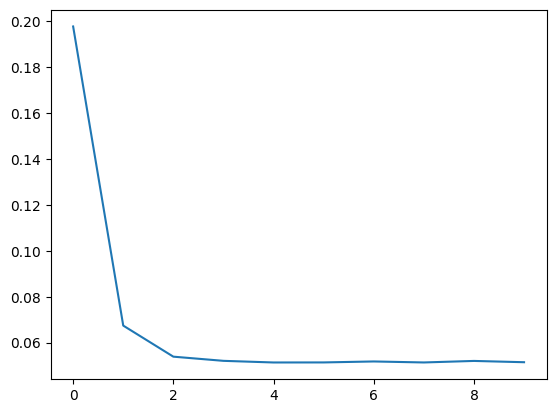

In [133]:
tau = 3
# we take a sliding window over the dataset and create samples of inputs to the model
x_train = torch.cat([y[i : i + tau][None, :] for i in range(N-tau)], dim=0)
y_train = torch.cat([y[i+tau][None] for i in range(N-tau)])

# create and fit model
model = LinearRegression(batch_size=16, epochs=10)
model.fit(x_train, y_train)

plt.plot(model.losses)

We can see that looking 1 step into the future leads to a good model

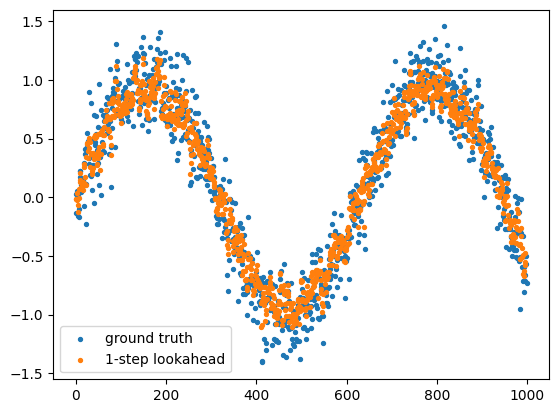

In [134]:
y_pred = model(x_train)
plt.scatter(x, y, s=8, label='ground truth')
plt.scatter(range(N-tau), y_pred.detach().numpy(), s=8, label='1-step lookahead')
plt.legend()

However, a big problem is that looking further into the future leads to accumulation of cumulative error, which causes very bad predictions.

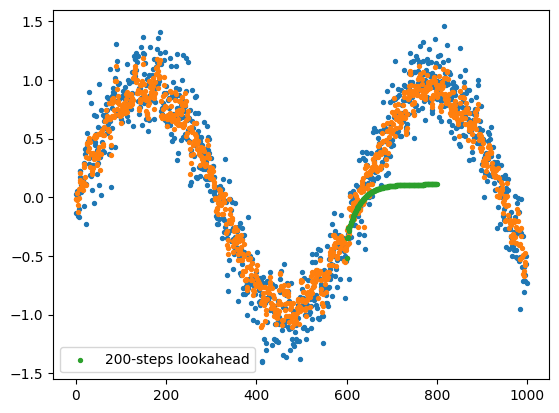

In [135]:
def look_k_steps_into_future(model, k, tau, x_instance):
    # concatenate predictions to make the next predictions
    for _ in range(k-tau):
        y_pred = model(x_instance[-tau:]).detach()
        x_instance = torch.cat([x_instance, y_pred])
    return x_instance

start = 600
steps = 200
future_preds = look_k_steps_into_future(model, steps, tau, x_train[start])

plt.scatter(x, y, s=8)
plt.scatter(range(N-tau), y_pred.detach().numpy(), s=8)
plt.scatter(range(start, start+steps), future_preds, s=8, label=f'{steps}-steps lookahead')
plt.legend()

## Basic RNN module

Maps input sequence to output sequence using update equations for each time step $t=1$ to $t = \tau$
\begin{align*}
    \textbf{a}^{(t)} &= \textbf{b} + \textbf{W}\textbf{h}^{(t-1)} + \textbf{U}\textbf{x}^{(t)}\\
    \textbf{h}^{(t)} &= \text{tanh}(\textbf{a}^{(t)})\\
    \hat{\textbf{y}}^{(t)} &= \text{softmax}(\textbf{c} + \textbf{V}\textbf{h}^{(t)})
\end{align*}
for 
- shared bias vectors $\textbf{b}, \textbf{c}$
- shared weight matrices:
  - $\textbf{W}$: hidden-to-hidden weights
  - $\textbf{U}$: input-to-hidden
  - $\textbf{V}$: hidden-to-output
- and input vectors $\textbf{x} \in \textbf{X}$

PyTorch handles the mathematics in an efficient way. In the following we define a custom torch module that contains the RNN as well as a linear layer followed by a softmax layer. This allows us to output a distribution of possible outputs for each sequence.   

In [136]:
class MyRNN(nn.Module):
    def __init__(self, 
                 num_inputs: int, 
                 num_hidden: int, 
                 num_outputs: int, 
                 n_layers: int,
                 dropout: float = 0.5) -> None:
        super().__init__()
        self.rnn = nn.RNN(num_inputs, num_hidden, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.out_layer = nn.LazyLinear(num_outputs)
    
    def forward(self, X: torch.Tensor, H: torch.Tensor = None):
        output, H = self.rnn(X, H)
        return self.out_layer(output), H

In [137]:
rnn = MyRNN(
    num_inputs=1,
    num_hidden=20,
    num_outputs=5,
    n_layers=3
)

batch_size, seq_len, n_inputs = 32, 50, 1
x = torch.randn(batch_size, seq_len, n_inputs)

y, h = rnn(x)

x.shape, y.shape, h.shape

(torch.Size([32, 50, 1]), torch.Size([32, 50, 5]), torch.Size([3, 32, 20]))

## Sequence Dataset

Since we operate on sequences when using RNNs, we will be using a dataset where the data is ordered sequentially. 

Specifically, to showcase how to use RNNs, we will use a simple noisy sine wave as our time series. We denote the sequence length of the input sequence by $\tau$. 

- `src_X`: source input covariate sequence (simple enumeration for now $[\textbf{x}^{(0)}, \textbf{x}^{(1)}, \dots, \textbf{x}^{(T)}]$)

- `src_fX`: source input feature sequence (simple noisy sine wave $[\textbf{y}^{(0)}, \textbf{y}^{(1)}, \dots, \textbf{y}^{(T)}]$)

- `tgt_X`: source target covariate sequence (simple enumeration for now $[\textbf{x}^{(T+1)}, \textbf{x}^{(T+2)}, \dots, \textbf{x}^{(T+\tau)}]$)

- `tgt_fX`: source input feature sequence (simple noisy sine wave $[\textbf{y}^{(T+1)}, \textbf{y}^{(T+2)}, \dots, \textbf{y}^{(T+\tau)}]$)

Our learning problem becomes the following: 

Given `src_fX`, we want to predict `tgt_fX`, or in other words:
$$
    [\hat{\textbf{y}}^{(T)}, \hat{\textbf{y}}^{(T+1)}, \dots, \hat{\textbf{y}}^{(T+\tau)}] = \text{RNN}(\textbf{y}^{(0)}, \textbf{y}^{(1)}, \dots, \textbf{y}^{(T)})
$$

Of course, a more sophisticated sequence model would consider both `src_X` and `src_fX` by aggregating these vectors and feeding it in the model. However, for simplicity, we will only use the feature sequence and only predict the feature sequence. 

In [138]:
from torch.utils.data import Dataset

# base class for an arbitrary sequence dataset
# key idea: samples are generated by sliding window over the entire sequence
class TimeSeriesDataset(Dataset):
    def __init__(
        self,
        X: torch.Tensor,
        fX: torch.Tensor,
        seq_len: int,
        shift: int
    ):
        """
        :param X: time steps (covariates)
        :param fX: features per time step
        :param seq_len: length of each sequence example in dataset
        :param shift: number of steps to shift the target values
        """
        self.seq_len = seq_len
        self.shift = shift
        self.X = X
        self.fX = fX

    def __getitem__(self, index):

        sample = (
            self.X[index : index + self.seq_len],
            self.fX[index : index + self.seq_len],
            self.X[index + self.seq_len : index + self.seq_len + self.shift],
            self.fX[index + self.seq_len : index + self.seq_len + self.shift],
        )
        return sample

    def __len__(self):
        return len(self.X) - self.seq_len - self.shift

In [146]:
# specific time series dataset of a noisy sine wave  
class SineSyntheticDataset(TimeSeriesDataset):
    def __init__(
        self,
        len_timeseries: int,
        seq_len: int,
        shift: int,
        alpha: float = 0.1,
        noise: float = 0.1
    ):

        X = torch.arange(0, len_timeseries, dtype=torch.float32).reshape(-1, 1)
        fX = torch.sin(alpha * X) + torch.randn_like(X) * noise
        super().__init__(X, fX, seq_len, shift)

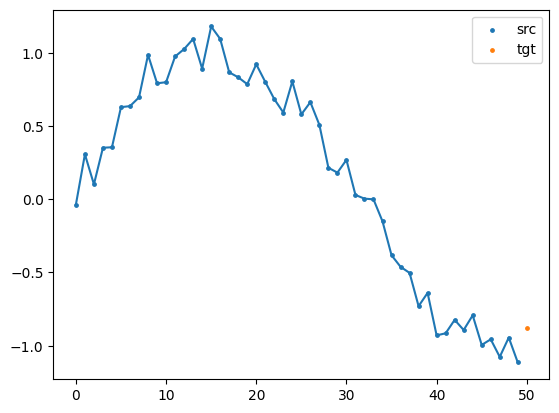

In [210]:
# let's test our dataset
dataset = SineSyntheticDataset(
    len_timeseries=5000, 
    seq_len=50,
    shift=1,
    alpha=0.1, 
    noise=0.1
)

src_x, src_fx, tgt_x, tgt_fx = dataset[0]

plt.scatter(src_x, src_fx, s=6, label='src')
plt.plot(src_x, src_fx)
plt.scatter(tgt_x, tgt_fx, s=6, label='tgt')
plt.legend()

## Define train and validation steps

It is good practice to encapsulate a single training and validation step in their own separate functions. 

Notice the differences between train/valid steps:
- `train_step` trains for a single epoch over a given dataloader, where the optimizer is used to perform gradient descent. Additionally, the gradients are clipped as to ensure that gradients do not explode. 
- `valid_step` validates for a single epoch over a given dataloader, without optimizer and within a `no_grad()` context so that no gradients are calculated. 

We use the MSE loss in this case to make single point predictions. The MSE loss implicitly regularizes the predictions such that the predictions converge to the mean prediction. In the case of volatile time series, the MSE loss may not be desired, due to the large variance of the volatility in the sequences. The MSE loss converges to the mean, meaning that predictions will deviate too much from the target. Instead, the Mean Absolute Error (MAE) could pose as an alternative, because the MAE converges to the median (instead of the mean). The median is a reliable averaging metric in situations where there are a lot of outliers (e.g., in volatile time series). 

If the desired output instead should be probabilistic, then we need to predict an interval. In this case, we can use Quantile loss, where we predict different percentiles of the output. Common quantiles are `[0.1, 0.5, 0.9]`, which means that we predict the $10\%$, $50\%$, $90\%$ quantiles. This is a nice option, as it provides some interpretability with respect to how much the model is certain about its predictions. Also notice that the $50\%$ quantile is the same as the median, i.e., it is the same as the MAE.

In the following, we simply use the MSE loss. 

In [211]:
def train_step(
        model: nn.Module, 
        dataloader: DataLoader, 
        optimizer: torch.optim,
        shift: int, 
        device: torch.device,
        grad_clip_val: int = 1
    ):
    model.train()
    batch_loss = []
    for _, batch_X, _, batch_y in dataloader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        y_pred, _ = model(batch_X)
        loss = F.mse_loss(y_pred[:, -shift:], batch_y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_val)
        optimizer.step()

        batch_loss.append(loss.detach().item())

    return np.sum(batch_loss) / len(batch_loss)

def valid_step(
        model: nn.Module, 
        dataloader: DataLoader,
        shift: int, 
        device: torch.device,
    ):
    model.eval()
    batch_loss = []
    with torch.no_grad():
        for _, batch_X, _, batch_y in dataloader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            y_pred, _ = model(batch_X)
            loss = F.mse_loss(y_pred[:, -shift:], batch_y)

            batch_loss.append(loss.detach().item())

    return np.sum(batch_loss) / len(batch_loss)

## Setup + train loop

Let's define some constants 

In [206]:
# Model constants
N_HIDDEN = 64
N_LAYERS = 1
DROPOUT_RATE = 0.0

# Training constants
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

# Dataset constants
LEN_TIMESERIES = 5000
SEQ_LEN = 20
SHIFT = 1

# check for possible GPU usage
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

We create a synthetic sine wave dataset with some added noise. We split this time series in 3 parts, i.e., training part, validation part, and test part. 

- `train_set` consists of the first 80 percent of the time series and will be used to optimize our model
- `valid_set` consists of the next 10 percent of the time series and will be used to monitor whether the model is over/underfitting
- `test_set` consists of the last 10 percent of the time series and will be used to test the model **once** after training has finished. We will also use this set for predictions.

In [207]:
from torch.utils.data import DataLoader

dataset = SineSyntheticDataset(
    len_timeseries=LEN_TIMESERIES, 
    seq_len=SEQ_LEN,
    shift=SHIFT,
    alpha=0.1, 
    noise=0.1
)

train_size = int(0.8 * LEN_TIMESERIES)
valid_size = int(0.1 * LEN_TIMESERIES)

train_set = torch.utils.data.Subset(dataset, range(train_size))
valid_set = torch.utils.data.Subset(dataset, range(train_size, train_size + valid_size))
test_set = torch.utils.data.Subset(dataset, range(train_size + valid_size, LEN_TIMESERIES))

train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

Let's train the model and plot the loss curves

epoch=0	train_loss=0.4438010439757378	valid_loss=0.35233223012515474
epoch=1	train_loss=0.2303570168873956	valid_loss=0.12628209910222463
epoch=2	train_loss=0.08970592267090274	valid_loss=0.058190436767680306
epoch=3	train_loss=0.03928040217367872	valid_loss=0.021235298631446704
epoch=4	train_loss=0.017127985074635473	valid_loss=0.0156820984557271
epoch=5	train_loss=0.015866910918585716	valid_loss=0.015287041264985288
epoch=6	train_loss=0.015291377286156338	valid_loss=0.015144021516399724
epoch=7	train_loss=0.014944623765205183	valid_loss=0.014932574172105108
epoch=8	train_loss=0.01468110236249143	valid_loss=0.014462455175817013
epoch=9	train_loss=0.014369051663144942	valid_loss=0.01412185640739543
epoch=10	train_loss=0.014071277282651394	valid_loss=0.014208450647337096
epoch=11	train_loss=0.013922545397954603	valid_loss=0.013889826168971402
epoch=12	train_loss=0.01375235071886451	valid_loss=0.013847146183252335
epoch=13	train_loss=0.013638773257093083	valid_loss=0.013956016594810145
e

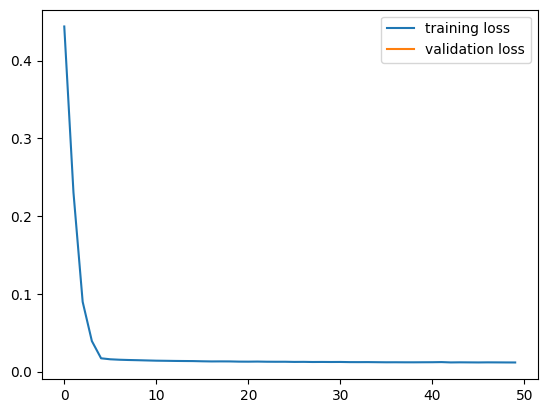

In [208]:
rnn = MyRNN(
    num_inputs=1, 
    num_hidden=N_HIDDEN,
    num_outputs=1, 
    n_layers=N_LAYERS,
    dropout=DROPOUT_RATE, 
).to(DEVICE)

optim = torch.optim.Adam(rnn.parameters(), LEARNING_RATE)

train_losses, valid_losses = [], []

for i in range(EPOCHS):
    
    train_loss = train_step(rnn, train_dataloader, optim, SHIFT, DEVICE)
    train_losses.append(train_loss)
    
    valid_loss = valid_step(rnn, valid_dataloader, SHIFT, DEVICE)
    valid_losses.append(valid_loss)

    print(f"epoch={i}\ttrain_loss={train_losses[-1]}\tvalid_loss={valid_losses[-1]}")

plt.plot(train_losses, label="training loss")
plt.plot(valid_loss, label="validation loss")
plt.legend()

Since the RNN model takes a sequence as its input and outputs the next value, we can make auto-regressive predictions. This means that we take the prediction and concatenate it to our input 

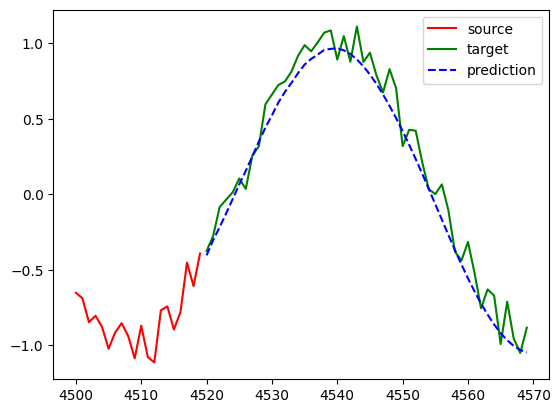

In [209]:
idx = 0
horizon = 50

src_x, src_fx, tgt_x, tgt_fx = test_set[idx]

output = src_fx.flatten().tolist()
tgt_X, tgt_fX = [], []


with torch.no_grad():

    for i in range(horizon):
        
        _, _, tgt_x, tgt_fx = test_set[idx+i]

        output_window = torch.tensor(output[-SEQ_LEN:]).reshape(-1, 1)
        y_pred, _ = rnn(output_window)
        output.append(y_pred[-1].item())
        tgt_X.append(tgt_x.item())
        tgt_fX.append(tgt_fx.item())

plt.plot(src_x, src_fx, 'r', label='source')
plt.plot(tgt_X, tgt_fX, 'g', label='target')
plt.plot(tgt_X, output[len(src_fx):], '--b', label='prediction')
plt.legend()